In [1]:
from pystk2_gymnasium import AgentSpec
import gymnasium as gym
import time
from sac_torch import AgentSac
from utils import plot_learning_curve

In [2]:
class ContinuousObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space['continuous']
    
    def observation(self, observation):
        return observation['continuous']

In [3]:
# (1) Setup the environment

player_name = "smail_gaetan_kart"
env_name = "supertuxkart/flattened_continuous_actions-v0"
n_envs = 4
n_steps = 3000
max_episode_steps = 200

def create_env(render_mode):
    env = gym.make(
        env_name,
        render_mode=render_mode, # human for video, else None 
        agent=AgentSpec(use_ai=False, name=player_name), # use_ai=False for using the "action" line of the workspace
    )
    env = ContinuousObservationWrapper(env)
    # env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

..:: Antarctica Rendering Engine 2.0 ::..
..:: Antarctica Rendering Engine 2.0 ::..
..:: Antarctica Rendering Engine 2.0 ::..
..:: Antarctica Rendering Engine 2.0 ::..
beginning of training


KeyboardInterrupt: 

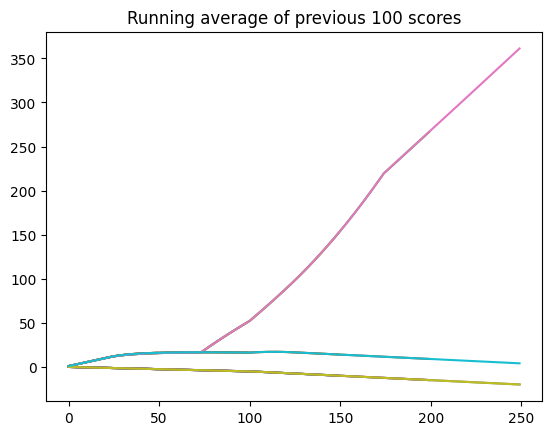

In [6]:
envs = [create_env(None) for _ in range(n_envs-1)]+[create_env("human")]
agent = AgentSac(input_dims=envs[0].observation_space.shape, env=envs[0],
                n_actions=envs[0].action_space.shape[0])

score_history = []
load_checkpoint = False

# if load_checkpoint:
#     agent.load_models()
#     envs[0].render(mode='human')

observations = [envs[i].reset()[0] for i in range(n_envs)]
scores = [0]*n_envs
scores_history = [[] for _ in range(n_envs)]

t_choose = 0
t_step = 0
t_learn = 0
print("beginning of training")

for k in range(n_steps):
    for i in range(n_envs):
        t = time.time()
        action = agent.choose_action(observations[i])
        t_choose += time.time()-t

        t = time.time()
        observation_, reward, terminated, truncated, info = envs[i].step(action)
        t_step += time.time() - t

        done = terminated or truncated
        scores[i] += reward
        agent.remember(observations[i], action, reward, observation_, done)

        if done:
            envs[i] = create_env(envs[i].render_mode)
            observations[i] = envs[i].reset()[0]

        t = time.time()
        if not load_checkpoint:
            agent.learn()
        t_learn += time.time()-t

        observations[i] = observation_
        scores_history[i].append(scores[i])

        if k%50==49:
            plot_learning_curve(list(range(k+1)), scores_history[i], "plots/stk_scores.png")
        if k==n_steps-1:
            envs[i].close()

print(f"{t_choose = } | {t_step = } | {t_learn = }")

In [5]:
for env in envs:
    env.close()